# RFM Prediction for Customer Transaction History in Bank

**Author** : [Lim Kim Hoong](https://github.com/LimKimHoong) ([kimhoong0324@gmail.com](mailto:kimhoong0324@gmail.com))

**Achievement** : Successfully developed and implemented an RFM prediction model using machine learning techniques, optimizing customer segmentation and future behavior forecasting. Achieved accurate predictions through a **Random Forest Regressor** with an **MSE of 0.000901** on testing datasets, effectively processing customer transaction data and generating actionable insights for enhancing targeted marketing strategies.

**Keywords** : *RFM Score, Prediction, Random Forest Regressor*
____

## <font color='Black'>Table of Content

1. [Introduction](#intro)

    A. [Overview](#overview)

    B. [Research Objective](#ro)
    
    C. [Research Question](#rq)
    
2. [Data Understanding](#du)
   
    A. [Library](#lib1)
   
    B. [Exploratory Data Analysis](#eda)
   
3. [Data Preparation](#dp)

4. [Modelling and Evaluation](#model)

    A. [Data Splitting](#ds)

    B. [Base Modelling](#bm)

    C. [Feature Importance](#fi)

    D. [Modelling](#modelling)

    E. [Model Saving](#ms)

5. [Prediction](#prediction)

6. [Conclusion](#conclusion)

7. [Future Work](#fw)

____

# <font color = 'Black'>1. Introduction<a name="intro"></a> 

#### <font color = 'Black'>A. Overview<a name="overview"></a> 

This project aims to predict future customer behavior based on their Recency, Frequency, and Monetary (RFM) metrics, helping businesses enhance customer segmentation and targeted marketing efforts. By merging customer transaction data with product-related information, this project applies various machine learning models, including Decision Tree Regressor (DT), Gradient Boosting Regressor (GBR), and Random Forest Regressor (RF), to forecast customer RFM scores. The process involves data preprocessing, feature engineering, and model evaluation using Mean Squared Error (MSE) for both training and testing phases. The final model, a Random Forest Regressor, is used to predict customer behavior over multiple future periods, with the results saved in a Parquet file for further analysis. The project's logging mechanism ensures that all key steps, including data import, preprocessing, modeling, and predictions, are thoroughly tracked for transparency and reproducibility.

#### <font color = 'Black'>B. Research Objective<a name="ro"></a>
    
1. To conduct a comprehensive analysis of machine learning models for predicting customer behavior based on RFM (Recency, Frequency, Monetary) scores.

2. To predict future RFM scores by utilizing transactional and product data to enhance customer segmentation and targeted marketing strategies.

3. To evaluate the performance of various regression models using Mean Squared Error (MSE) as the key metric for accuracy and reliability.

#### <font color = 'Black'>C. Research Question<a name="rq"></a>

1. **How can machine learning models be utilized to accurately predict future customer behavior based on RFM metrics (Recency, Frequency, Monetary)?**
   - Achieved by developing a predictive model that forecasts future customer RFM scores, enhancing segmentation and personalization strategies.

2. **What impact does merging transactional and product data have on the accuracy of customer behavior predictions in RFM analysis?**
   - Demonstrated through data preprocessing and merging customer and product datasets, leading to improved feature engineering and model performance.

3. **Which machine learning algorithms offer the most reliable performance for RFM-based prediction models when evaluated using Mean Squared Error (MSE) as the metric?**
   - Achieved by comparing multiple models (Decision Tree, Gradient Boosting, Random Forest) and identifying Random Forest as the most effective model for minimizing prediction error.

_______

# <font color = 'Black'>2. Data Understanding<a name = "du"></a>
    
The dataset used in this project was collected in 2018 and comprises over one million real-world transactions that occurred within a banking environment. The data has been encrypted to protect privacy while still reflecting key patterns in customer spending behavior. Each transaction is tied to a unique customer identifier, denoted as 'cid,' which serves as the key indicator for individual users. In addition to transaction details, the dataset includes demographic information for each customer, such as age, gender, and location, which provides deeper insights into their spending habits and allows for more granular analysis of customer behavior.

## <font color = 'black'>A. Library<a name = "lib1"></a>

In [5]:
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as py
import seaborn as sns

# Always good to set a seed for reproducibility
import numpy as np
SEED = 7
np.random.seed(SEED)

from sklearn.preprocessing import LabelEncoder

import time

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB  # Naive Bayes is not typically used for regression, consider removing this model
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

import joblib
import os

In [4]:
rfm = pd.read_parquet('../data/customer_rfm_demo_product.parquet', engine='pyarrow')
product = pd.read_parquet('../data/product_gap.parquet', engine='pyarrow')

## <font color = 'black'>B. Exploratory Data Analysis<a name = "eda"></a>

In [8]:
rfm.columns

Index(['cid', 'transaction_month', 'transaction_year', 'recency', 'frequency',
       'monetary_value', 'recency_score', 'recency_segment', 'frequency_score',
       'frequency_segment', 'monetary_score', 'monetary_segment', 'rfm_score',
       'customer_segment', 'gender', 'state', 'city', 'postcode', 'dob', 'age',
       'nationality', 'occupation', 'education', 'marital_status',
       'no_dependents', 'phone_number', 'religion', 'race',
       'disability_status', 'income_level', 'income_range_million_idr',
       'has_credit_card', 'has_current_account', 'has_debit_card', 'has_loan'],
      dtype='object')

In [9]:
product.columns

Index(['MoB', 'cid', 'gender', 'state', 'city', 'postcode', 'dob', 'age',
       'nationality', 'occupation', 'education', 'marital_status',
       'no_dependents', 'phone_number', 'loan', 'religion', 'race',
       'disability_status', 'income_level', 'income_range_million_idr',
       'recommend_credit_card_MoB', 'recommend_loan_MoB',
       'recommend_debit_card_MoB', 'reccomend_current_account_MoB',
       'orphan_product', 'pair_product', 'pairing_gap'],
      dtype='object')

In [3]:
rfm.describe()

,transaction_month,transaction_year,recency,frequency,monetary_value,recency_score,frequency_score,monetary_score,rfm_score,dob,age,no_dependents
count,5.943286e+06,5943286.0,5.943286e+06,5.943286e+06,5.943286e+06,5.943286e+06,5.943286e+06,5.943286e+06,5.943286e+06,5943286,5.943286e+06,5.943286e+06
mean,6.500266e+00,2018.0,2.649509e+01,6.209454e+00,1.414304e+07,1.401082e+00,2.773472e+00,3.000000e+00,9.699775e-02,1975-11-15 23:55:25.722638944,4.832787e+01,2.565678e+00
min,1.000000e+00,2018.0,1.000000e+00,1.000000e+00,3.000000e-02,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1943-09-15 00:00:00,1.700000e+01,0.000000e+00
25%,4.000000e+00,2018.0,2.500000e+01,5.000000e+00,9.968142e+03,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e-02,1961-12-15 00:00:00,3.400000e+01,1.000000e+00
50%,7.000000e+00,2018.0,2.800000e+01,6.000000e+00,4.941559e+05,1.000000e+00,3.000000e+00,3.000000e+00,8.000000e-02,1976-02-26 00:00:00,4.800000e+01,2.000000e+00
75%,1.000000e+01,2018.0,3.000000e+01,8.000000e+00,2.665566e+06,2.000000e+00,4.000000e+00,4.000000e+00,1.400000e-01,1990-05-07 00:00:00,6.200000e+01,3.000000e+00
max,1.200000e+01,2018.0,3.100000e+01,4.100000e+01,1.395939e+12,5.000000e+00,5.000000e+00,5.000000e+00,1.000000e+00,2006-09-14 00:00:00,8.000000e+01,1.000000e+01
std,3.451985e+00,0.0,4.415998e+00,2.393168e+00,1.841640e+09,7.060477e-01,1.339675e+00,1.414214e+00,8.089504e-02,NaN,1.716481e+01,2.499981e+00


In [4]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5943286 entries, 0 to 5943285
Data columns (total 35 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   cid                       object        
 1   transaction_month         int32         
 2   transaction_year          int32         
 3   recency                   int64         
 4   frequency                 int64         
 5   monetary_value            float64       
 6   recency_score             int64         
 7   recency_segment           category      
 8   frequency_score           int64         
 9   frequency_segment         category      
 10  monetary_score            int64         
 11  monetary_segment          category      
 12  rfm_score                 float64       
 13  customer_segment          category      
 14  gender                    object        
 15  state                     object        
 16  city                      object        
 17  postcode

In [5]:
product.describe()

,MoB,dob,age,no_dependents
count,1.245802e+06,1293361,1.293361e+06,1.293361e+06
mean,5.546259e+01,1976-04-03 15:38:18.972985856,4.794549e+01,2.633099e+00
min,1.000000e+01,1943-09-15 00:00:00,1.700000e+01,0.000000e+00
25%,1.700000e+01,1963-03-01 00:00:00,3.400000e+01,1.000000e+00
50%,4.200000e+01,1976-08-06 00:00:00,4.800000e+01,2.000000e+00
75%,7.200000e+01,1990-01-25 00:00:00,6.100000e+01,4.000000e+00
max,8.060000e+02,2006-09-14 00:00:00,8.000000e+01,1.000000e+01
std,5.110038e+01,NaN,1.655463e+01,2.533592e+00


In [6]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293361 entries, 0 to 1293360
Data columns (total 27 columns):
 #   Column                         Non-Null Count    Dtype         
---  ------                         --------------    -----         
 0   MoB                            1245802 non-null  float64       
 1   cid                            1293361 non-null  object        
 2   gender                         1293361 non-null  object        
 3   state                          1293361 non-null  object        
 4   city                           1293361 non-null  object        
 5   postcode                       1293361 non-null  object        
 6   dob                            1293361 non-null  datetime64[ns]
 7   age                            1293361 non-null  int64         
 8   nationality                    1293361 non-null  object        
 9   occupation                     1293361 non-null  object        
 10  education                      1293361 non-null  objec

_________

# <font color = 'Black'>3. Data Prepraration<a name = "dp"></a>
    
In this phase, the focus is on refining the dataset to ensure it is suitable for analysis. This involves filtering the data to include only relevant transactions, dropping redundant or unnecessary columns, and merging multiple datasets to create a comprehensive view. These steps are crucial for enhancing data quality and ensuring that the models are built on accurate and meaningful information. By combining transaction data with demographic details, the dataset is prepared for efficient analysis and predictive modeling.

In [10]:
# Step 1: Outer Join LTR with LM on 'tr_acc_no' and 'l_acc_no'
#temp = pd.merge(loanmaster, loanhist, left_on='l_acc_no', right_on='ln_acc_no', how='outer')
temp = pd.merge(rfm, product, left_on ='cid', right_on = 'cid', how = 'inner')

In [11]:
print(temp.columns)
len(temp)

Index(['cid', 'transaction_month', 'transaction_year', 'recency', 'frequency',
       'monetary_value', 'recency_score', 'recency_segment', 'frequency_score',
       'frequency_segment', 'monetary_score', 'monetary_segment', 'rfm_score',
       'customer_segment', 'gender_x', 'state_x', 'city_x', 'postcode_x',
       'dob_x', 'age_x', 'nationality_x', 'occupation_x', 'education_x',
       'marital_status_x', 'no_dependents_x', 'phone_number_x', 'religion_x',
       'race_x', 'disability_status_x', 'income_level_x',
       'income_range_million_idr_x', 'has_credit_card', 'has_current_account',
       'has_debit_card', 'has_loan', 'MoB', 'gender_y', 'state_y', 'city_y',
       'postcode_y', 'dob_y', 'age_y', 'nationality_y', 'occupation_y',
       'education_y', 'marital_status_y', 'no_dependents_y', 'phone_number_y',
       'loan', 'religion_y', 'race_y', 'disability_status_y', 'income_level_y',
       'income_range_million_idr_y', 'recommend_credit_card_MoB',
       'recommend_loan_MoB

7231186

In [12]:
# selecting rows based on condition 
filtered = temp[temp['pairing_gap'] == 1] 

In [13]:
print(filtered.columns)
len(filtered)

Index(['cid', 'transaction_month', 'transaction_year', 'recency', 'frequency',
       'monetary_value', 'recency_score', 'recency_segment', 'frequency_score',
       'frequency_segment', 'monetary_score', 'monetary_segment', 'rfm_score',
       'customer_segment', 'gender_x', 'state_x', 'city_x', 'postcode_x',
       'dob_x', 'age_x', 'nationality_x', 'occupation_x', 'education_x',
       'marital_status_x', 'no_dependents_x', 'phone_number_x', 'religion_x',
       'race_x', 'disability_status_x', 'income_level_x',
       'income_range_million_idr_x', 'has_credit_card', 'has_current_account',
       'has_debit_card', 'has_loan', 'MoB', 'gender_y', 'state_y', 'city_y',
       'postcode_y', 'dob_y', 'age_y', 'nationality_y', 'occupation_y',
       'education_y', 'marital_status_y', 'no_dependents_y', 'phone_number_y',
       'loan', 'religion_y', 'race_y', 'disability_status_y', 'income_level_y',
       'income_range_million_idr_y', 'recommend_credit_card_MoB',
       'recommend_loan_MoB

1699137

In [15]:
# Get all column names and sort them in ascending order
sorted_columns = sorted(filtered.columns)
print(sorted_columns)

['MoB', 'age_x', 'age_y', 'cid', 'city_x', 'city_y', 'customer_segment', 'disability_status_x', 'disability_status_y', 'dob_x', 'dob_y', 'education_x', 'education_y', 'frequency', 'frequency_score', 'frequency_segment', 'gender_x', 'gender_y', 'has_credit_card', 'has_current_account', 'has_debit_card', 'has_loan', 'income_level_x', 'income_level_y', 'income_range_million_idr_x', 'income_range_million_idr_y', 'loan', 'marital_status_x', 'marital_status_y', 'monetary_score', 'monetary_segment', 'monetary_value', 'nationality_x', 'nationality_y', 'no_dependents_x', 'no_dependents_y', 'occupation_x', 'occupation_y', 'orphan_product', 'pair_product', 'pairing_gap', 'phone_number_x', 'phone_number_y', 'postcode_x', 'postcode_y', 'race_x', 'race_y', 'reccomend_current_account_MoB', 'recency', 'recency_score', 'recency_segment', 'recommend_credit_card_MoB', 'recommend_debit_card_MoB', 'recommend_loan_MoB', 'religion_x', 'religion_y', 'rfm_score', 'state_x', 'state_y', 'transaction_month', 'tra

In [16]:
# Drop both 'Age' and 'City' columns
df_dropped = filtered.drop(['age_y', 'city_y', 'disability_status_y', 'dob_y',
                            'education_y', 'gender_y', 'income_level_y', 'income_range_million_idr_y',
                            'marital_status_y', 'nationality_y', 'no_dependents_y', 
                            'occupation_y', 'phone_number_y', 'postcode_y', 
                            'race_y', 'religion_y', 'state_y'], axis=1)

In [17]:
df_dropped.columns

Index(['cid', 'transaction_month', 'transaction_year', 'recency', 'frequency',
       'monetary_value', 'recency_score', 'recency_segment', 'frequency_score',
       'frequency_segment', 'monetary_score', 'monetary_segment', 'rfm_score',
       'customer_segment', 'gender_x', 'state_x', 'city_x', 'postcode_x',
       'dob_x', 'age_x', 'nationality_x', 'occupation_x', 'education_x',
       'marital_status_x', 'no_dependents_x', 'phone_number_x', 'religion_x',
       'race_x', 'disability_status_x', 'income_level_x',
       'income_range_million_idr_x', 'has_credit_card', 'has_current_account',
       'has_debit_card', 'has_loan', 'MoB', 'loan',
       'recommend_credit_card_MoB', 'recommend_loan_MoB',
       'recommend_debit_card_MoB', 'reccomend_current_account_MoB',
       'orphan_product', 'pair_product', 'pairing_gap'],
      dtype='object')

In [19]:
len(df_dropped.columns)
len(df_dropped)

1699137

In [20]:
df_dropped['cid'].nunique()

141269

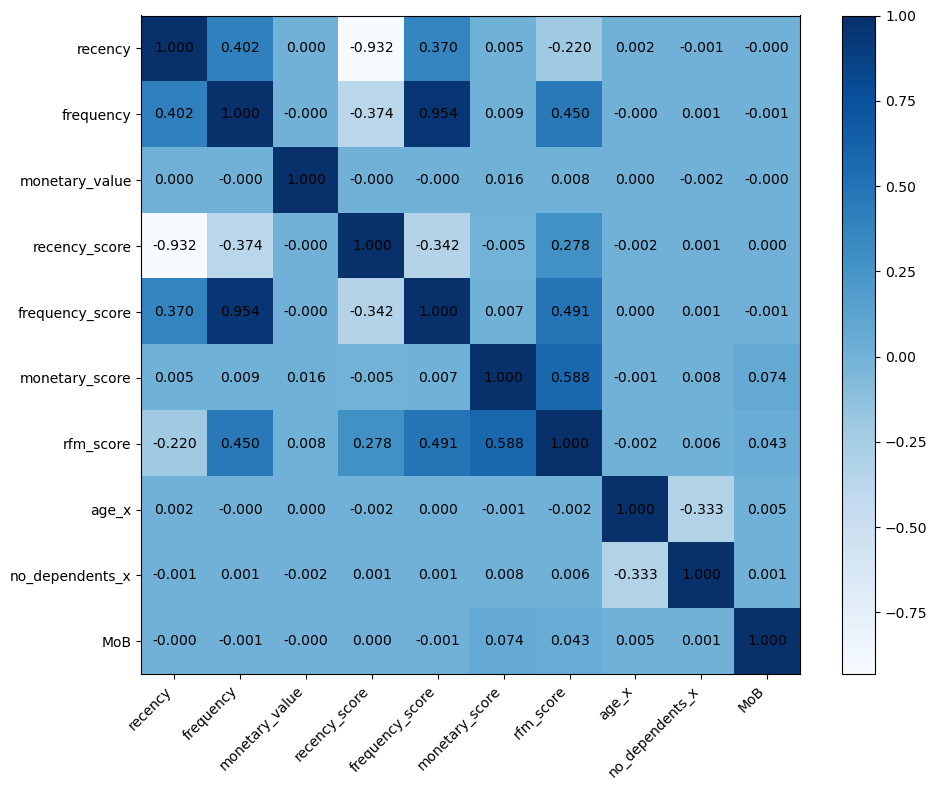

In [21]:
numerical_df = df_dropped.select_dtypes(include=['int64', 'float64'])

matrix = numerical_df.corr()

plt.figure(figsize=(10, 8))  # Increase the size of the plot

# Assuming 'matrix' is your correlation matrix (pandas DataFrame)
plt.imshow(matrix, cmap='Blues')

# Adding colorbar
plt.colorbar()

# Extracting variable names
variables = matrix.columns

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

# Annotating the correlation matrix with correlation values
for i in range(len(matrix)):
    for j in range(len(matrix)):
        plt.text(j, i, f'{matrix.iloc[i, j]:.3f}', ha='center', va='center', color='black')

# Display the plot
plt.tight_layout()
plt.show()


In [22]:
# Check for missing values 
df_dropped.isna().sum().sum() / len(df_dropped) * 100

0.0

In [23]:
len(df_dropped.columns)

44

In [24]:
df_dropped['transaction_year'].head(10)

5831    2018
5832    2018
5833    2018
5834    2018
5835    2018
5836    2018
5837    2018
5838    2018
5839    2018
5840    2018
Name: transaction_year, dtype: int32

In [25]:
# Convert numeric month to abbreviated month names (Jan, Feb, Mar, etc.)
df_dropped['month_name'] = pd.to_datetime(df_dropped['transaction_month'], format='%m').dt.strftime('%b')

In [26]:
# Combine 'month' and 'year' into one column
df_dropped['month_year'] = df_dropped['month_name'].astype(str) + ' ' + df_dropped['transaction_year'].astype(str)
df_dropped['month_year'].head(10)
## Convert 'year' column to string and concatenate with 'month'
#df['month_year'] = df['month'] + ' ' + df['year'].astype(str)

In [29]:
final = df_dropped.drop(['transaction_month', 'transaction_year', 'month_name',  'dob_x'], axis=1)

In [30]:
print(final.columns)
print(len(final.columns))

Index(['cid', 'recency', 'frequency', 'monetary_value', 'recency_score',
       'recency_segment', 'frequency_score', 'frequency_segment',
       'monetary_score', 'monetary_segment', 'rfm_score', 'customer_segment',
       'gender_x', 'state_x', 'city_x', 'postcode_x', 'age_x', 'nationality_x',
       'occupation_x', 'education_x', 'marital_status_x', 'no_dependents_x',
       'phone_number_x', 'religion_x', 'race_x', 'disability_status_x',
       'income_level_x', 'income_range_million_idr_x', 'has_credit_card',
       'has_current_account', 'has_debit_card', 'has_loan', 'MoB', 'loan',
       'recommend_credit_card_MoB', 'recommend_loan_MoB',
       'recommend_debit_card_MoB', 'reccomend_current_account_MoB',
       'orphan_product', 'pair_product', 'pairing_gap', 'month_year'],
      dtype='object')
42


In [33]:
final['month_year'].unique()

array(['Jan 2018', 'Feb 2018', 'Mar 2018', 'Apr 2018', 'May 2018',
       'Jun 2018', 'Jul 2018', 'Aug 2018', 'Sep 2018', 'Oct 2018',
       'Nov 2018', 'Dec 2018'], dtype=object)

In [34]:
final.iloc[-1,:]

cid                                     9999977782991700
recency                                               30
frequency                                              8
monetary_value                                    908.12
recency_score                                          1
recency_segment                                  Dormant
frequency_score                                        4
frequency_segment                               Frequent
monetary_score                                         1
monetary_segment                                 Minimal
rfm_score                                           0.03
customer_segment                 Dormant Minimal Spender
gender_x                                            Male
state_x                                     Kuala Lumpur
city_x                                       Wangsa Maju
postcode_x                                         53300
age_x                                                 19
nationality_x                  

In [35]:
categorical_list = ['recency_segment','frequency_segment','monetary_segment','customer_segment',
                    'gender_x', 'state_x', 'city_x', 'nationality_x', 'occupation_x', 'education_x', 
                    'marital_status_x', 'religion_x', 'race_x', 'disability_status_x', 'income_level_x', 'income_range_million_idr_x', 
                    'has_credit_card', 'has_current_account', 'has_debit_card', 'has_loan', 'loan', 'recommend_credit_card_MoB', 
                    'recommend_loan_MoB', 'recommend_debit_card_MoB', 'reccomend_current_account_MoB', 'orphan_product', 'pair_product', 'pairing_gap', 
                    'month_year']

In [36]:
final_copy = final.copy()

In [37]:
final_copy.isna().sum()

cid                              0
recency                          0
frequency                        0
monetary_value                   0
recency_score                    0
recency_segment                  0
frequency_score                  0
frequency_segment                0
monetary_score                   0
monetary_segment                 0
rfm_score                        0
customer_segment                 0
gender_x                         0
state_x                          0
city_x                           0
postcode_x                       0
age_x                            0
nationality_x                    0
occupation_x                     0
education_x                      0
marital_status_x                 0
no_dependents_x                  0
phone_number_x                   0
religion_x                       0
race_x                           0
disability_status_x              0
income_level_x                   0
income_range_million_idr_x       0
has_credit_card     

In [39]:
lab_encoder = LabelEncoder()

for item in categorical_list:
    try : 
        final_copy[item] = lab_encoder.fit_transform(final_copy[item])
    except : 
        print("Fail to encode in : ", item)

In [40]:
## Move column 'A' to the end
df = final_copy[[col for col in final_copy.columns if col != 'rfm_score'] + ['rfm_score']]

In [41]:
df['month_year'].nunique()

12

In [43]:
df_names = list(df.columns.values)
df_names

['cid',
 'recency',
 'frequency',
 'monetary_value',
 'recency_score',
 'recency_segment',
 'frequency_score',
 'frequency_segment',
 'monetary_score',
 'monetary_segment',
 'customer_segment',
 'gender_x',
 'state_x',
 'city_x',
 'postcode_x',
 'age_x',
 'nationality_x',
 'occupation_x',
 'education_x',
 'marital_status_x',
 'no_dependents_x',
 'phone_number_x',
 'religion_x',
 'race_x',
 'disability_status_x',
 'income_level_x',
 'income_range_million_idr_x',
 'has_credit_card',
 'has_current_account',
 'has_debit_card',
 'has_loan',
 'MoB',
 'loan',
 'recommend_credit_card_MoB',
 'recommend_loan_MoB',
 'recommend_debit_card_MoB',
 'reccomend_current_account_MoB',
 'orphan_product',
 'pair_product',
 'pairing_gap',
 'month_year',
 'rfm_score']

In [ ]:
def HeatMap(df,x=True):
        correlations = df.corr(numeric_only=True)
        ## Create color map ranging between two colors
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        fig, ax = plt.subplots(figsize=(10, 10))
        fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',square=True, linewidths=.5, annot=x, cbar_kws={"shrink": .75})
        fig.set_xticklabels(fig.get_xticklabels(), rotation = 90, fontsize = 10)
        fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 10)
        plt.tight_layout()
        plt.show()

HeatMap(df,x=True)

____

# <font color = 'Black'>4. Modelling and Evaluation<a name = "model"></a>

## <font color = 'black'>A. Data Splitting<a name = "ds"></a>

In the Data Splitting phase, the prepared dataset is divided into two distinct subsets: one for training the predictive models and the other for testing their performance. Specifically, 75% of the data is allocated for training, allowing the models to learn underlying patterns and relationships within the data. The remaining 25% is reserved for testing, providing an unbiased evaluation of the model's accuracy and generalizability. This approach ensures that the model is not only well-fitted to the training data but also capable of performing effectively on unseen data, which is critical for robust predictive analytics.

In [44]:
X = df[df_names[0:-2]]
Y = df[df_names[-1]]

In [45]:
X_train, X_test, y_train, y_test =train_test_split(X,Y,
                                                   test_size=0.25,
                                                   random_state=0,
                                                   stratify=df['rfm_score'])

## <font color = 'black'>B. Base Modelling<a name = "bm"></a>

In the Base Modelling sub-session, a foundational analysis is conducted to establish baseline performance metrics for various regression algorithms. This stage involves selecting a diverse range of models, including Decision Tree Regression, Gradient Boosting Regression, and Random Forest Regression, to evaluate their predictive capabilities on the training dataset. By fitting each model to the data and assessing their performance using metrics such as Mean Squared Error (MSE), this phase aims to identify which algorithms provide the best initial predictions. The insights gained here will inform subsequent modelling decisions and optimizations, laying the groundwork for more advanced analyses in later stages of the project.

In [47]:
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR', LinearRegression()))
    basedModels.append(('KNN', KNeighborsRegressor()))
    basedModels.append(('CART', DecisionTreeRegressor()))
    #basedModels.append(('SVM', SVR()))
    basedModels.append(('AB', AdaBoostRegressor()))
    basedModels.append(('GBM', GradientBoostingRegressor()))
    basedModels.append(('RF', RandomForestRegressor()))
    basedModels.append(('ET', ExtraTreesRegressor()))
    return basedModels

In [48]:
def BasedLine2(X_train, y_train, models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'neg_mean_squared_error'  # Use MSE for regression

    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

    return names, results

def BasedLine3(X_train, y_train, models):
    # Evaluation metric
    scoring = 'neg_mean_squared_error'  # Use MSE for regression

    results = []
    names = []
    for name, model in models:
        # Train the model on the entire training dataset
        model.fit(X_train, y_train)
        
        # Evaluate the model using MSE on the training data
        y_pred = model.predict(X_train)
        mse = mean_squared_error(y_train, y_pred)
        
        results.append(mse)
        names.append(name)
        
        msg = "%s: %f" % (name, mse)
        print(msg)

    return names, results

In [49]:
class PlotBoxR(object):
    def __Trace(self,nameOfFeature,value): 
        trace = go.Box(
            y=value,
            name = nameOfFeature,
          
        )
        return trace
    def PlotResult(self,first_model,first_result):
        data = []
        for i in range(len(first_model)):
            data.append(self.__Trace(first_model[i],first_result[i]))
        py.iplot(data)

In [50]:
def ScoreDataFrame(names,results):
    def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))

    scores = []
    for r in results:
        scores.append(floatingDecimals(r.mean(),4))

    scoreDataFrame = pd.DataFrame({'Model':names, 'Score': scores})
    return scoreDataFrame

In [ ]:
models = GetBasedModel()
option_model,option_result = BasedLine2(X_train, y_train,models)

In [ ]:
basedLineScore = ScoreDataFrame(option_model,option_result)
basedLineScore

## <font color = "Black">C. Feature Importance<a name = "fi"></a>
    
It is a techniques where we calculate the score for all input variables from our dataset for a given model. The score we calculated simply representing the importanceness of each input variable. For example, a higher score means that the specific variable will have a larger effect on the model that is being used in prediction of a variable. 

As such, bagged decision trees like Random Forest and Extra Trees can be used to estimate the importance of features.

In [56]:
clf = ExtraTreesRegressor(n_estimators=250, random_state=SEED)
clf.fit(X_train, y_train)

ExtraTreesRegressor(n_estimators=250, random_state=7)

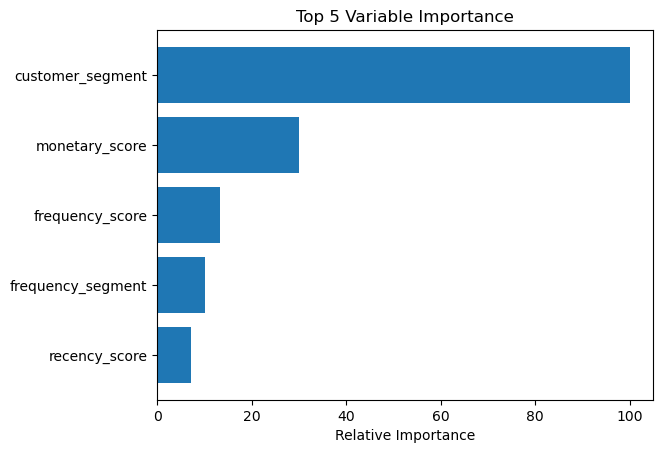

In [57]:
# Get the feature importance
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
top_5_idx = sorted_idx[-5:]
pos = np.arange(top_5_idx.shape[0]) + .5
plt.barh(pos, feature_importance[top_5_idx], align='center')
plt.yticks(pos, df.columns[top_5_idx])
plt.xlabel('Relative Importance')
plt.title('Top 5 Variable Importance')
plt.show()


**Analysis**

As shown in plotting above, we focus on the top 3 variables that affected the most on the dependent variables, namely `customer_segment`, `monetary_score` and `frequency_score`. 

In [235]:
df_feature_imp=df[['cid','customer_segment','monetary_score','frequency_score','month_year','rfm_score']].head(40)

In [78]:
df_feature_imp_name = df_feature_imp.columns
df_feature_imp_name

Index(['cid', 'customer_segment', 'monetary_score', 'frequency_score',
       'month_year', 'rfm_score'],
      dtype='object')

## <font color = "Black">D. Modelling<a name = "modelling"></a>

In this session, we concentrate on retraining the model by prioritizing and selecting only those features that exhibit a significant level of importance concerning the dependent variable. This step is vital, particularly when working with large and intricate datasets, as it allows us to streamline the model and enhance its performance.

Additionally, we focus our efforts on the top three models identified from the baseline modeling results. By honing in on these high-performing models, we aim to maximize predictive accuracy while minimizing the complexity of our analysis.

In [79]:
X = df_feature_imp[df_feature_imp_name[1:-1]]
Y = df_feature_imp[df_feature_imp_name[-1]]
X_train, X_test, y_train, y_test =train_test_split(X,Y,
                                                   test_size=0.25,
                                                   random_state=0,
                                                   stratify=df['rfm_score'])

,customer_segment,monetary_score,frequency_score,month_year
5831,1,5,1,4
5832,3,4,1,3
5833,0,5,2,7
5834,0,4,3,0
5835,3,4,5,8
...,...,...,...,...
7231157,2,1,2,1
7231158,2,1,3,11
7231159,2,1,3,10
7231160,2,1,1,9


In [8]:
def GetBasedModel2():
    basedModels = []
    basedModels.append(('CART', DecisionTreeRegressor()))
    #basedModels.append(('SVM', SVR()))
    basedModels.append(('GBM', GradientBoostingRegressor()))
    basedModels.append(('RF', RandomForestRegressor()))
    return basedModels

def BasedLine3(X_train, y_train, models):
    # Evaluation metric
    scoring = 'neg_mean_squared_error'  # Use MSE for regression

    results = []
    names = []
    for name, model in models:
        start_time = time.time()
        # Train the model on the entire training dataset
        model.fit(X_train, y_train)
        
        # Evaluate the model using MSE on the training data
        y_pred = model.predict(X_train)
        mse = mean_squared_error(y_train, y_pred)
        
        results.append(mse)
        names.append(name)
        
        msg = "--- %s: %f MSE ---" % (name, mse)
        print(msg)
        print("--- %s seconds ---" % (time.time() - start_time))
        print()

    return names, results

def TestModels(X_test, y_test, models):
    # Evaluation metric
    scoring = 'neg_mean_squared_error'  # Use MSE for regression

    results = []
    names = []
    for name, model in models:
        start_time = time.time()
        
        # Predict on the test dataset
        y_pred = model.predict(X_test)
        
        # Evaluate the model using MSE on the test data
        mse = mean_squared_error(y_test, y_pred)
        
        results.append(mse)
        names.append(name)
        
        msg = "--- %s: %f MSE ---" % (name, mse)
        print(msg)
        print("--- %s seconds ---" % (time.time() - start_time))
        print()

    return names, results

In [81]:
models = GetBasedModel2()
option_model,option_result = BasedLine3(X_train, y_train,models)

--- CART: 0.000897 MSE ---
--- 0.7029011249542236 seconds ---

--- GBM: 0.000949 MSE ---
--- 48.85388398170471 seconds ---

--- RF: 0.000897 MSE ---
--- 61.95802402496338 seconds ---



In [82]:
test_model,test_result = TestModels(X_test, y_test,models)

--- CART: 0.000900 MSE ---
--- 0.05319690704345703 seconds ---

--- GBM: 0.000951 MSE ---
--- 0.8362679481506348 seconds ---

--- RF: 0.000901 MSE ---
--- 3.0948519706726074 seconds ---



**Analysis**

The Mean Squared Error (MSE) score obtained from the testing dataset clearly indicates that the Random Forest model outperforms the others. Therefore, we will focus our analysis and predictions using the Random Forest Regressor.

## <font color = "Black">E. Model Saving<a name = "ms"></a>

In this sub-session, we focus on the process of saving the trained model using the Pickle library. Pickle is a powerful tool in Python that allows us to serialize and deserialize Python objects, making it easy to save complex data structures such as machine learning models to disk. By saving our model as a Pickle file, we can efficiently store it for future use without the need for retraining. This not only streamlines our workflow but also ensures that we can quickly deploy our model for predictions or further analysis at any time. The subsequent steps involve demonstrating how to implement this serialization process effectively.

In [84]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [10]:
def save_model(model, filename):
    # Define the model folder
    model_folder = 'model'
    
    # Check if the model folder exists
    if not os.path.exists(model_folder):
        # Create the model folder if it doesn't exist
        os.makedirs(model_folder)
        print(f"Created folder: {model_folder}")
    else:
        print(f"Folder already exists: {model_folder}")
    
    # Create the full path for the filename
    full_path = os.path.join(model_folder, filename)
    
    # Save the trained model to a file
    joblib.dump(model, full_path)
    print(f"Model saved to {full_path}")

In [ ]:
save_model(model, 'RF_Regressor')

____

# <font color = 'Black'>5. Prediction<a name = "prediction"></a>

In this sub-session, we delve into the crucial phase of making predictions using our trained model. After thoroughly evaluating and refining our model, we will apply it to the test dataset to generate predictions for the target variable. This step is vital as it allows us to assess the model's performance in real-world scenarios and understand how accurately it can predict outcomes based on unseen data. We will also explore the interpretation of the predictions and their implications for decision-making, providing insights into the practical applications of our predictive modeling efforts.

In [ ]:
def load_model(filename):
    # Define the model folder
    model_folder = 'model'
    
    # Create the full path for the filename
    full_path = os.path.join(model_folder, filename)
    
    # Load the model from the file
    model = joblib.load(full_path)
    print(f"Model loaded from {full_path}")
    return model

load_model('RF_Regressor.pkl')

In [164]:
# Filter rows where 'month_year' is equal to 11
filtered_df = df_feature_imp[df_feature_imp['month_year'] == 11]
filtered_df.head(20)
filtered_df['cid'].nunique()

141083

In [165]:
# Assuming df is your DataFrame
cleaned_df = filtered_df.drop_duplicates(subset='cid', keep='last')
len(cleaned_df)
cleaned_df.head(20)

,cid,customer_segment,monetary_score,frequency_score,month_year,rfm_score
5839,0021745891533247,0,4,3,11,0.11
12897,0049921364861732,1,5,1,11,0.04
16533,0065750931643856,0,3,2,11,0.11
22076,0085026799453360,3,5,5,11,0.24
22181,0085415696984959,0,5,3,11,0.14
24495,0093119366176305,0,5,3,11,0.14
27602,0104209177861612,1,5,1,11,0.04
28238,0107075306119946,0,5,3,11,0.14
29989,0113172069460886,0,5,2,11,0.09
30820,0115556902470944,1,5,1,11,0.04


In [188]:
def data_processing(data: pd.DataFrame, n:int) -> None:
    print("n here : ", n)
    #cleaned_df['month_year'] = cleaned_df['month_year'].replace(11, 12)
    data.loc[:,'month_year'] = n   
    return data

In [261]:
dfs = {}
n = 18
for i in range(12, n):
    temp_df = cleaned_df.copy()  # Create a copy of cleaned_df to avoid overwriting
    temp_df['month_year'] = i  # Assign the correct month_year value
    dfs[f'df{i-11}'] = temp_df.head(10)  # Store the modified DataFrame in the dictionary

In [206]:
def batch_predict(column_name, model, X_batch):
    # Use the loaded model to predict on new batch data
    rfm_predicted = [] 
    X_batch=X_batch[['customer_segment','monetary_score','frequency_score','month_year']]
    # Iterate through each row in the DataFrame and make predictions
    for index, row in X_batch.iterrows():
        #print("Row : ", type(row))
        #row = row.drop(labels=['cid'])
        result = model.predict(row.to_frame().T)
        rfm_predicted.append(result.item())
        #print(row)

    return rfm_predicted

In [263]:
rfm_predictions = {}
n = 18
count = n - 11
for i in range(1, count):
    rfm_predictions[f'rfm_p{i}'] = batch_predict(f'rfm_p{i}', model, dfs[f'df{i}'])

In [231]:
final = df.assign(rfm_pm1 = rfm_predictions['rfm_p1'], 
               rfm_pm2 = rfm_predictions['rfm_p2'],
               rfm_pm3 = rfm_predictions['rfm_p3'],
               rfm_pm4 = rfm_predictions['rfm_p4'],
               rfm_pm5 = rfm_predictions['rfm_p5'],
               rfm_pm6 = rfm_predictions['rfm_p6'])

In [233]:
for i in range(1, count):
    # Perform batch prediction and immediately assign the result to the DataFrame
    final = final.assign(**{f'rfm_pm{i}': batch_predict(f'rfm_p{i}', model, dfs[f'df{i}'])})

In [234]:
final

,cid,customer_segment,monetary_score,frequency_score,month_year,rfm_score,rfm_pm1,rfm_pm2,rfm_pm3,rfm_pm4,rfm_pm5,rfm_pm6
5839,0021745891533247,0,4,3,17,0.11,0.110000,0.110000,0.110000,0.110000,0.110000,0.110000
12897,0049921364861732,1,5,1,17,0.04,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000
16533,0065750931643856,0,3,2,17,0.11,0.110000,0.110000,0.110000,0.110000,0.110000,0.110000
22076,0085026799453360,3,5,5,17,0.24,0.270403,0.270403,0.270403,0.270403,0.270403,0.270403
22181,0085415696984959,0,5,3,17,0.14,0.140000,0.140000,0.140000,0.140000,0.140000,0.140000
24495,0093119366176305,0,5,3,17,0.14,0.140000,0.140000,0.140000,0.140000,0.140000,0.140000
27602,0104209177861612,1,5,1,17,0.04,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000
28238,0107075306119946,0,5,3,17,0.14,0.140000,0.140000,0.140000,0.140000,0.140000,0.140000
29989,0113172069460886,0,5,2,17,0.09,0.090000,0.090000,0.090000,0.090000,0.090000,0.090000
30820,0115556902470944,1,5,1,17,0.04,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000


In [177]:
# Save DataFrame to a Parquet file
final.to_parquet('../data/predicted_rfm.parquet', engine='pyarrow', index=False)

print("DataFrame successfully saved to Parquet file!")

DataFrame successfully saved to Parquet file!


____

# <font color = 'Black'>6. Conclusion<a name = "conclusion"></a>

In conclusion, this project on RFM (Recency, Frequency, Monetary) score prediction has provided valuable insights into customer behavior and spending patterns. By leveraging a robust dataset comprising over a million transactions, we effectively developed and refined predictive models to assess customer value. Our analysis highlighted the importance of feature selection and model optimization, allowing us to focus on the most influential variables that contribute to accurate predictions.

The Random Forest Regressor emerged as the top-performing model, demonstrating superior predictive accuracy compared to other algorithms. This not only validates our approach but also reinforces the significance of employing advanced machine learning techniques in customer analytics.

The findings from this project can serve as a foundation for enhancing customer relationship management strategies, tailoring marketing efforts, and ultimately driving business growth. By understanding and predicting customer behavior through RFM scores, organizations can make informed decisions that foster customer loyalty and increase profitability. Future work may include expanding the dataset, integrating additional variables, and continuously updating the models to adapt to changing consumer behaviors.

____

# <font color = 'Black'>7. Future Work<a name = "fw"></a>

Looking ahead, there are several avenues for further exploration and enhancement of the RFM score prediction project:

1. **Dataset Expansion**: To improve model robustness, future work could involve integrating additional datasets that capture more diverse customer interactions and transactions. This may include data from various channels such as online shopping, mobile apps, and customer service interactions, allowing for a more comprehensive view of customer behavior.

2. **Feature Engineering**: Additional features could be developed to enrich the existing dataset. This might include creating variables that capture seasonal trends, promotional responses, or customer engagement metrics. Advanced feature engineering could lead to improved model performance and more accurate predictions.

3. **Model Optimization**: While the Random Forest Regressor has proven effective, exploring alternative algorithms, such as ensemble methods, neural networks, or gradient-boosting techniques, could yield even better results. Additionally, hyperparameter tuning and cross-validation could further enhance model accuracy.

4. **Real-Time Prediction Capabilities**: Implementing real-time prediction capabilities would allow businesses to dynamically adjust their marketing strategies based on current customer behavior. Developing a system for continuous model training and updating could ensure that predictions remain relevant and accurate over time.

5. **Integration with Business Applications**: The RFM score prediction model could be integrated into existing customer relationship management (CRM) systems to provide actionable insights directly to marketing teams. This would enable businesses to tailor their campaigns more effectively based on predicted customer value.

6. **Monitoring and Evaluation**: Establishing a framework for ongoing monitoring and evaluation of the model’s performance in a production environment will be essential. This could involve tracking key metrics, such as precision, recall, and overall business impact, to ensure that the model continues to provide value.

By pursuing these future work directions, the project can evolve to better meet the needs of businesses, enhance customer insights, and drive strategic decision-making based on data-driven predictions.